As the number of groups increases, which algorithm performs better at scaling?

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Step 1: Load the data
df = pd.read_parquet(
    "results/psc-baselines-2.parquet", 
    columns=["algorithm", "n_groups", "np", "value"],
    filters=[("dist", "==", "uniform"), ("n_rows", "==", 8_000_000), ("attribute", "==", "aggregation_time")],
)

# Step 2: Preprocess
df["value"] = df["value"].apply(lambda x: float(x.removesuffix("ms")))
df = df.groupby(["algorithm", "n_groups", "np"])["value"].mean().reset_index()
df = df.rename(columns={"value": "latency"})

# Step 3: Add Speedup Column
baseline = df[df["np"] == 1][["algorithm", "n_groups", "latency"]]
baseline = baseline.rename(columns={"latency": "baseline_latency"})
df = df.merge(baseline, on=["algorithm", "n_groups"], how="left")
df["speedup"] = df["baseline_latency"] / df["latency"]
df = df.drop(columns=["baseline_latency"])

# Step 4: Add Tolerance Column
# Find the latency at the minimal n_groups for each (dist, algorithm, np)
min_group_latency = (
    df.loc[df.groupby(["algorithm", "np"])["n_groups"].idxmin()]
    [["algorithm", "np", "latency"]]
    .rename(columns={"latency": "min_group_latency"})
)

df = df.merge(min_group_latency, on=["algorithm", "np"], how="left")
df["slowdown"] = df["latency"] / df["min_group_latency"]
df = df.drop(columns=["min_group_latency"])

# Step 5: Display
for algorithm in df["algorithm"].unique():
    display(df[(df["np"] == df["np"].max()) & (df["algorithm"] == algorithm)])


What's the latency and speedup for these baseline algorithms?

In [95]:
import pandas as pd

# Step 1: Load the data
df = pd.read_parquet(
    "results/psc-baselines-2.parquet", 
    columns=["algorithm", "n_groups", "np", "trial_id", "value"],
    filters=[
        ("dist", "==", "uniform"), 
        ("n_rows", "==", 80_000_000), 
        ("attribute", "in", [
            "aggregation_time",
            "elapsed_time",
        ]),
        ("algorithm", "in", [
            "two-phase-central-merge-xxhash",
            "two-phase-tree-merge",
            "two-phase-radix-xxhash",
            "omp-lock-free-hash-table",
            "duckdb", "polars",
        ])
    ],
)

# Step 2: Preprocess
df["value"] = df["value"].apply(lambda x: float(x.removesuffix("ms")))
df = df.rename(columns={"value": "latency"})
df = df.groupby(["algorithm", "n_groups", "np"], as_index=False)["latency"].mean()

# Step 3: Add Speedup Column
baseline = df[df["np"] == 1][["algorithm", "n_groups", "latency"]]
baseline = baseline.rename(columns={"latency": "baseline_latency"})
df = df.merge(baseline, on=["algorithm", "n_groups"], how="left")
df["speedup"] = df["baseline_latency"] / df["latency"]
df = df.drop(columns=["baseline_latency"])

display(df.sample(5))


,algorithm,n_groups,np,latency,speedup
68,polars,20000,16,658.3290,5.386954
90,polars,20000000,4,6904.8404,2.270280
91,polars,20000000,8,3390.5928,4.623358
168,two-phase-tree-merge,200000,1,2325.8000,1.000000
100,two-phase-central-merge-xxhash,20000,16,118.3000,14.651733


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def format_number(n):
    if n >= 1_000_000_000: return f"{n//1_000_000}B"
    if n >= 1_000_000: return f"{n//1_000_000}M"
    if n >= 1_000: return f"{n//1_000}K"
    return str(n)

sns.set_theme(style="whitegrid")
for groups in sorted(df["n_groups"].unique()):
    subset = df[df["n_groups"] == groups]
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=subset, x="np", y="latency", hue="algorithm", marker="o")
    plt.title(f"Latency Curve (n_groups = {format_number(groups)})")
    plt.xlabel("Number of Threads (np)")
    plt.ylabel("Latency (ms)")
    plt.yscale("log")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(title="Algorithm")
    plt.tight_layout()
    plt.savefig(f"results/latency_curve_ngroups_{format_number(groups)}.png", dpi=300)
    plt.show()


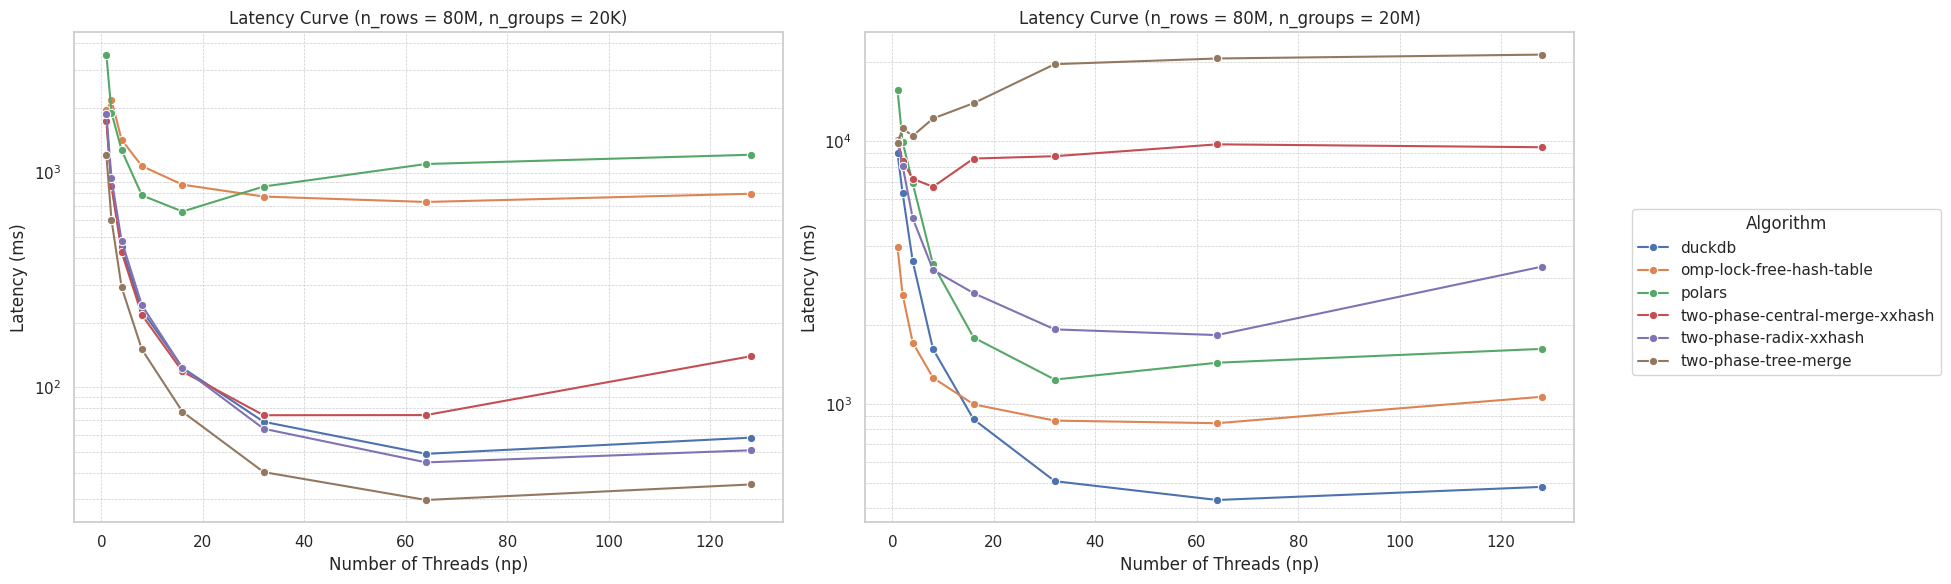

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

def format_number(n):
    if n >= 1_000_000_000: return f"{n//1_000_000}B"
    if n >= 1_000_000: return f"{n//1_000_000}M"
    if n >= 1_000: return f"{n//1_000}K"
    return str(n)

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})
lines, labels = [], []
for ax, groups in zip(axes, [20_000, 20_000_000]):
    subset = df[df["n_groups"] == groups]
    line = sns.lineplot(data=subset, x="np", y="latency", hue="algorithm", marker="o", ax=ax)
    ax.set_title(f"Latency Curve (n_rows = 80M, n_groups = {format_number(groups)})")
    ax.set_xlabel("Number of Threads (np)")
    ax.set_ylabel("Latency (ms)")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    if not lines and not labels: lines, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()
fig.legend(lines, labels, title="Algorithm", loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.savefig("results/latency_curve_ngroups_20K_20M.png", dpi=300, bbox_inches='tight')
plt.show()


Does adaptive execution perform better?

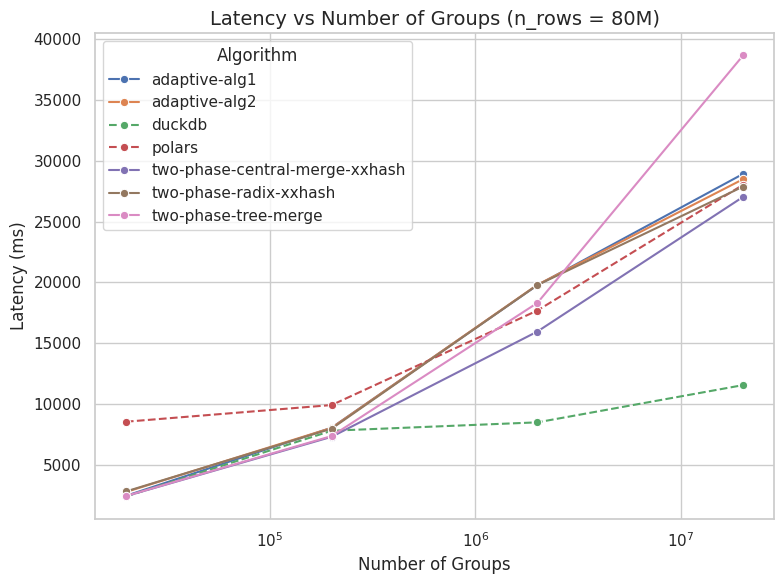

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the data
df = pd.read_parquet(
    "results/adaptive.parquet", 
    columns=["algorithm", "n_groups", "np", "trial_id", "value"],
    filters=[
        ("dist", "==", "uniform"), 
        ("n_rows", "==", 80_000_000), 
        ("attribute", "in", [
            "aggregation_time",
            "elapsed_time",
        ]),
        ("algorithm", "in", [
            "adaptive-alg1", "adaptive-alg2",
            "two-phase-central-merge-xxhash",
            "two-phase-tree-merge",
            "two-phase-radix-xxhash",
            # "omp-lock-free-hash-table", # This comparison is unfair. It knows the number of rows ahead of time...
            "duckdb", "polars",
        ])
    ],
)

# Step 2: Preprocess
df["value"] = df["value"].apply(lambda x: float(x.removesuffix("ms")))
df = df.rename(columns={"value": "latency"})
df = df.groupby(["algorithm", "n_groups", "np"], as_index=False)["latency"].mean()

# Define which algorithms should have dashed lines
dashed_algorithms = {"duckdb", "polars"}

# Create a new column for linestyle based on algorithm
df["linestyle"] = df["algorithm"].apply(lambda x: "--" if x in dashed_algorithms else "-")

# Set the theme
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

# Plot manually looping through each algorithm
for algorithm, group_df in df.groupby("algorithm"):
    linestyle = "--" if algorithm in dashed_algorithms else "-"
    sns.lineplot(
        data=group_df,
        x="n_groups",
        y="latency",
        label=algorithm,
        marker="o",
        linestyle=linestyle
    )

# Set log scale and labels
plt.xscale("log")
plt.xlabel("Number of Groups", fontsize=12)
plt.ylabel("Latency (ms)", fontsize=12)
plt.title("Latency vs Number of Groups (n_rows = 80M)", fontsize=14)
plt.legend(title="Algorithm", loc="best")
plt.tight_layout()
plt.savefig("results/latency_vs_groups.png", dpi=300)
plt.show()
